In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

sns.set_style('darkgrid')
%matplotlib inline

In [157]:
df = pd.read_csv('./term-deposit-marketing-2020.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


# Data Description

> **Age:** Age of customer  
> **Job:** Type of job  
> **Marital:** Marital status   
> **Education:**  
> **Default:** Has credit in default?  
> **Balance:** Average yearly balance, in euros  
> **Housing:** Has a housing loan?  
> **Loan:** Has personal loan?  
> **Contact:** Contact communication type  
> **Day:** Last contact day of the month  
> **Month:** Last contact month of year  
> **Duration:** Last contact duration, in seconds  
> **Campaign:** Number of contacts performed during this campaign and for this client (includes last contact)  

# EDA

In [42]:
df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [158]:
## descriptive statistics of customers who signed up for term deposits

df.loc[(df['y'] == 'yes')].describe()

,age,balance,day,duration,campaign
count,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000
mean,39.844959,1588.495856,15.827003,682.958564,2.414365
std,11.001984,2924.894429,8.557604,431.287174,2.306015
min,19.000000,-3058.000000,1.000000,8.000000,1.000000
25%,31.000000,141.000000,8.000000,364.000000,1.000000
50%,37.000000,620.000000,16.000000,629.000000,2.000000
75%,47.000000,1820.500000,22.000000,913.000000,3.000000
max,95.000000,45248.000000,31.000000,3881.000000,32.000000


In [159]:
## descriptive statistics of customers who did not sign up for term deposits

df.loc[(df['y'] == 'no')].describe()

,age,balance,day,duration,campaign
count,37104.000000,37104.000000,37104.000000,37104.000000,37104.000000
mean,40.599208,1249.752533,16.032072,221.408042,2.918688
std,9.525450,2900.722436,8.255850,206.360022,3.298031
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,50.000000,8.000000,95.000000,1.000000
50%,39.000000,395.000000,17.000000,164.000000,2.000000
75%,48.000000,1286.000000,21.000000,280.000000,3.000000
max,94.000000,102127.000000,31.000000,4918.000000,63.000000


Taking a look at the difference in customers who sign up for a term deposit and those that don't, the only continuous feature that has a noticeable difference is the duration of the phone call. The customers who sign up are on the phone much longer than those that are not interested with the average duration being 11 minutes for customers who sign up and ~4 minutes for those who don't. The average yearly balance for those who sign up is also slightly higher than those who don't but the difference is not very significant.

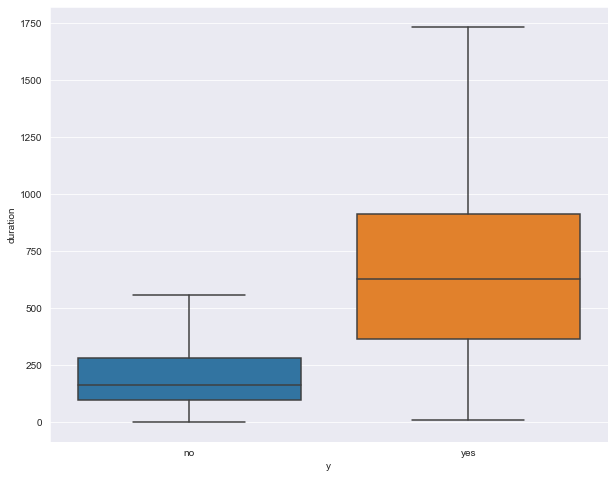

In [45]:
## graph the difference in duration to see the discrepancy more easily

plt.figure(figsize=(10, 8))
sns.boxplot(x='y', y='duration', data=df, showfliers=False)
plt.show()

Looking at this graph it is easy to see how much longer a customer that is interested will stay on the call. Most calls with customers that sign up for a term deposit are 

In [161]:
## replace binary categorical columns with 0s and 1s

cat_columns = ['default', 'housing', 'loan', 'y']

for name in cat_columns:
    df[name].replace(to_replace={'yes':1, 'no':0}, inplace=True)

In [162]:
df.corr()

,age,default,balance,housing,loan,day,duration,campaign,y
age,1.000000,-0.014857,0.081517,-0.179606,0.000041,-0.011689,-0.036270,0.016204,-0.020273
default,-0.014857,1.000000,-0.070069,-0.019229,0.075006,0.006287,-0.008597,0.012135,-0.006559
balance,0.081517,-0.070069,1.000000,-0.049946,-0.080596,0.011662,0.014072,-0.008137,0.030232
housing,-0.179606,-0.019229,-0.049946,1.000000,0.004266,-0.050622,0.022455,-0.054823,-0.054336
loan,0.000041,0.075006,-0.080596,0.004266,1.000000,0.005838,-0.003952,0.000582,-0.031029
day,-0.011689,0.006287,0.011662,-0.050622,0.005838,1.000000,-0.032983,0.165429,-0.006420
duration,-0.036270,-0.008597,0.014072,0.022455,-0.003952,-0.032983,1.000000,-0.088387,0.461169
campaign,0.016204,0.012135,-0.008137,-0.054823,0.000582,0.165429,-0.088387,1.000000,-0.040350
y,-0.020273,-0.006559,0.030232,-0.054336,-0.031029,-0.006420,0.461169,-0.040350,1.000000


Looking at the correlation matrix, it looks like duration of the phone call is the biggest predictor of whether or not a customer will sign up for a term deposit with a 46% correlation.

In [163]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,0


In [175]:
## number of people that signed up split by job and education

df.groupby(['job', 'marital'])['y'].sum().unstack()

marital,divorced,married,single
job,,,
admin,62,155,134
blue-collar,50,336,149
entrepreneur,11,58,19
housemaid,8,34,11
management,93,339,244
retired,47,100,4
self-employed,12,53,47
services,40,114,84
student,0,4,78


In [177]:
## number of people that did not sign up split by job and education

df.groupby(['job', 'marital'])['y'].count().unstack() - df.groupby(['job', 'marital'])['y'].sum().unstack()

marital,divorced,married,single
job,,,
admin,618,2178,1336
blue-collar,680,6423,1745
entrepreneur,154,960,203
housemaid,152,776,106
management,925,4352,2213
retired,224,982,80
self-employed,112,866,324
services,494,2181,997
student,4,36,402


In [166]:
## create a groupby object separating customers by job and education to find their average call duration

group = df.groupby(['job', 'education']).agg(avg_duration=('duration', 'mean'))
group.reset_index(inplace=True)

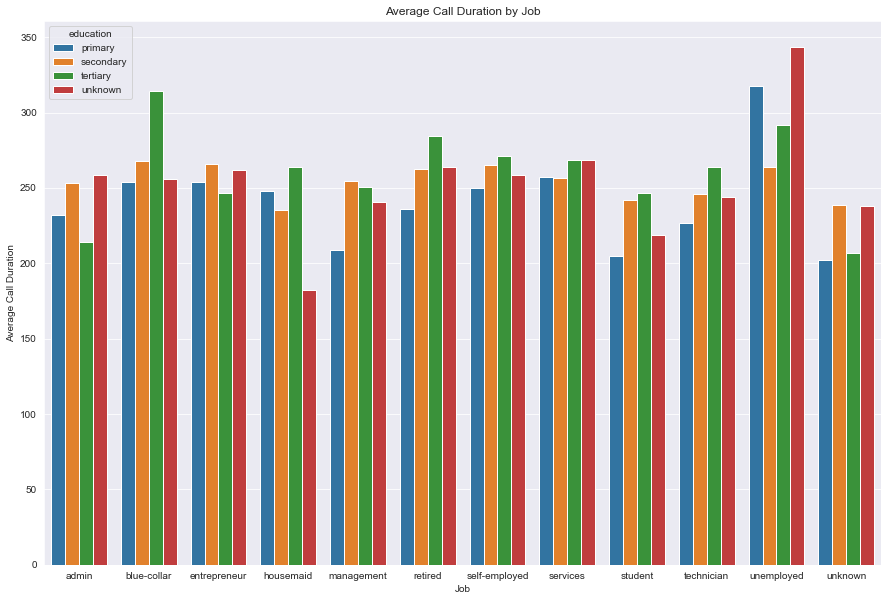

In [167]:
plt.figure(figsize=(15, 10))
sns.barplot(x='job', y='avg_duration', hue='education', data=group)
plt.xlabel('Job')
plt.ylabel('Average Call Duration')
plt.title('Average Call Duration by Job')
plt.show()

In [182]:
## create a groupby object separating customers by job and marital status to find their average call duration

group = df.groupby(['job', 'marital']).agg(avg_duration=('duration', 'mean'))
group.reset_index(inplace=True)

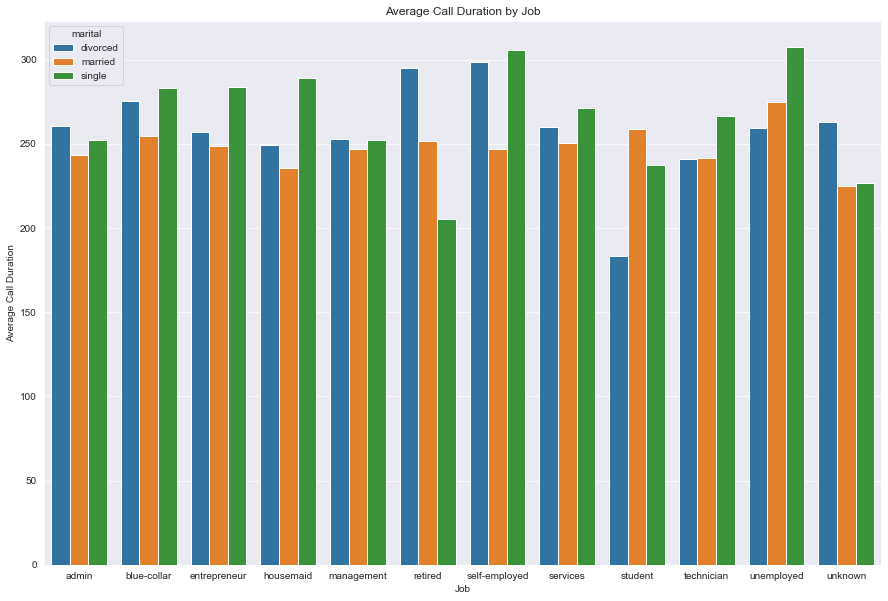

In [183]:
plt.figure(figsize=(15, 10))
sns.barplot(x='job', y='avg_duration', hue='marital', data=group)
plt.xlabel('Job')
plt.ylabel('Average Call Duration')
plt.title('Average Call Duration by Job')
plt.show()

# Data Preparation

In [31]:
## check for null values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [32]:
df['job'].value_counts()

blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64

In [33]:
df['education'].value_counts()

secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64

In [34]:
df['contact'].value_counts()

cellular     24914
unknown      12765
telephone     2321
Name: contact, dtype: int64

Even though there are no null values in the dataset, there are 'unknown' values in the job, education, and contact columns. Most of the unknown values are a small part of the column other than contact. Let's take a look and see if there is any way to fill in the unknown values.

In [41]:
print(f'Number of yes for cellular: {len(df.loc[(df["y"] == "yes") & (df["contact"] == "cellular")])}')
print(f'Number of no for cellular: {len(df.loc[(df["y"] == "no") & (df["contact"] == "cellular")])}')
print(f'Ratio of yes to no for cellular: {len(df.loc[(df["y"] == "yes") & (df["contact"] == "cellular")])/len(df.loc[(df["y"] == "no") & (df["contact"] == "cellular")])}\n')

print(f'Number of yes for telephone: {len(df.loc[(df["y"] == "yes") & (df["contact"] == "telephone")])}')
print(f'Number of no for telephone: {len(df.loc[(df["y"] == "no") & (df["contact"] == "telephone")])}')
print(f'Ratio of yes to no for telephone: {len(df.loc[(df["y"] == "yes") & (df["contact"] == "telephone")])/len(df.loc[(df["y"] == "no") & (df["contact"] == "telephone")])}\n')

print(f'Number of yes for unknown: {len(df.loc[(df["y"] == "yes") & (df["contact"] == "unknown")])}')
print(f'Number of no for unknown: {len(df.loc[(df["y"] == "no") & (df["contact"] == "unknown")])}')
print(f'Ratio of yes to no for unknown: {len(df.loc[(df["y"] == "yes") & (df["contact"] == "unknown")])/len(df.loc[(df["y"] == "no") & (df["contact"] == "unknown")])}\n')

Number of yes for cellular: 2233
Number of no for cellular: 22681
Ratio of yes to no for cellular: 0.0984524491865438

Number of yes for telephone: 166
Number of no for telephone: 2155
Ratio of yes to no for telephone: 0.07703016241299304

Number of yes for unknown: 497
Number of no for unknown: 12268
Ratio of yes to no for unknown: 0.0405119008803391



Looking at the ratios of yes's and no's between methods of contact, all the ratios are pretty similar suggesting that the method of communication does not influence whether or not a customer will sign up for a term deposit. Because of this, I'll leave the unknown values as is.

In [47]:
## only 7% of people sign up for a term deposit

df['y'].value_counts(normalize=True)

no     0.9276
yes    0.0724
Name: y, dtype: float64

In [85]:
X = df.drop(labels=['y'], axis=1)
y = df['y']

In [86]:
## drop the day and month columns because they are unnecessary

X.drop(['day', 'month'], axis=1, inplace=True)

In [87]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign
0,58,management,married,tertiary,0,2143,1,0,unknown,261,1
1,44,technician,single,secondary,0,29,1,0,unknown,151,1
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,76,1
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,92,1
4,33,unknown,single,unknown,0,1,0,0,unknown,198,1


In [88]:
## create dummies for categorical variables except for job because job has too many unique values

marital_dummies = pd.get_dummies(X['marital'], drop_first=True)
education_dummies = pd.get_dummies(X['education'], prefix='education', drop_first=True)
contact_dummies = pd.get_dummies(X['contact'], prefix='contact', drop_first=True)

X_dummies = pd.concat([X.drop(['marital', 'education', 'contact'], axis=1), 
                       marital_dummies, education_dummies, contact_dummies], axis=1)
X_dummies.head()

,age,job,default,balance,housing,loan,duration,campaign,married,single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown
0,58,management,0,2143,1,0,261,1,1,0,0,1,0,0,1
1,44,technician,0,29,1,0,151,1,0,1,1,0,0,0,1
2,33,entrepreneur,0,2,1,1,76,1,1,0,1,0,0,0,1
3,47,blue-collar,0,1506,1,0,92,1,1,0,0,0,1,0,1
4,33,unknown,0,1,0,0,198,1,0,1,0,0,1,0,1


In [89]:
## use label encoder on job

labelencoder = LabelEncoder()
X_dummies['job'] = labelencoder.fit_transform(X_dummies['job'])

In [90]:
X_dummies.head()

,age,job,default,balance,housing,loan,duration,campaign,married,single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown
0,58,4,0,2143,1,0,261,1,1,0,0,1,0,0,1
1,44,9,0,29,1,0,151,1,0,1,1,0,0,0,1
2,33,2,0,2,1,1,76,1,1,0,1,0,0,0,1
3,47,1,0,1506,1,0,92,1,1,0,0,0,1,0,1
4,33,11,0,1,0,0,198,1,0,1,0,0,1,0,1


# Modeling

Now that the data has been taken care of let's run it through some models.

In [91]:
## split data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.3, random_state=42)

# Logistic Regression

In [92]:
## create a logistic regression model

logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)

## find out accuracy score

y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

Training Accuracy:  0.933
Testing Accuracy:  0.9334166666666667


In [93]:
cv = KFold(n_splits=5, random_state=10, shuffle=True)
scores = cross_val_score(logreg, X_dummies, y, scoring='accuracy', cv=cv)

print('Accuracy: {}'.format(np.mean(scores)))

Accuracy: 0.933425


A standard logistic regression model performs extremely well with a training accuracy of 93% and a testing acuracy of 93%. Let's see if we can improve upon the performance by tuning the hyperparameters.

In [94]:
## run all features through a logistic regression model
## create grid parameter for logistic regression
logreg = LogisticRegression(solver='liblinear')
logistic_grid = [{'C': [1, 50, 2000, 1e15],
                  'penalty': ['l1', 'l2']}]

te_log_gridsearch = GridSearchCV(estimator=logreg,
                                   param_grid=logistic_grid,
                                   scoring='accuracy',
                                   cv=5)

te_log_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid=[{'C': [1, 50, 2000, 1000000000000000.0],
                          'penalty': ['l1', 'l2']}],
             scoring='accuracy')

In [95]:
## find out accuracy score

y_hat_train = te_log_gridsearch.predict(X_train)
y_hat_test = te_log_gridsearch.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

Training Accuracy:  0.9327857142857143
Testing Accuracy:  0.933


Performance stays the same after tuning hyperparameters with an accuracy score of 93%.

# Random Forest

In [96]:
## create a random forest model

rf = RandomForestClassifier(random_state=27)
rf.fit(X_train, y_train)
    
## find out accuracy score
    
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

Training Accuracy:  1.0
Testing Accuracy:  0.9318333333333333


In [97]:
cv = KFold(n_splits=5, random_state=10, shuffle=True)
scores = cross_val_score(rf, X_dummies, y, scoring='accuracy', cv=cv)

print('Accuracy: {}'.format(np.mean(scores)))

Accuracy: 0.931775


The random forest model performs better on the training set with a 100% accuracy rate but performs similarly to the logistic regression model with a training accuracy of 93%

In [98]:
## define a function to plot imporant features

def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

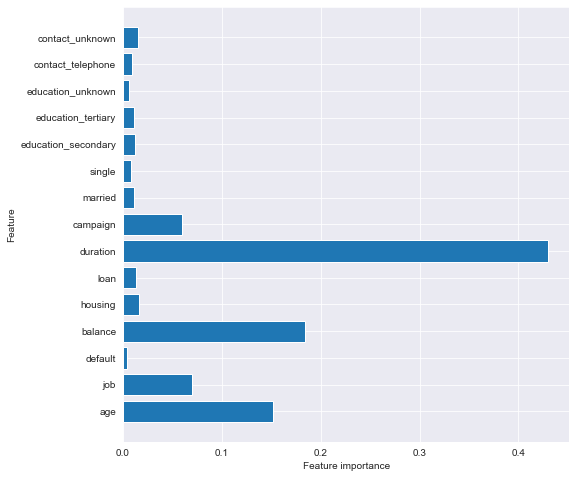

In [99]:
plot_feature_importances(rf)

The feature importance chart reinforces that the duration of the call is the most important feature in determining whether or not a customer will sign up for a term deposit. The second and third most important features are balance and age.

# LightGBM

In [100]:
## create lightGBM model

lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)

## find out accuracy score

y_hat_train = lgbm.predict(X_train)
y_hat_test = lgbm.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

Training Accuracy:  0.9486071428571429
Testing Accuracy:  0.9326666666666666


In [105]:
cv = KFold(n_splits=5, random_state=10, shuffle=True)
scores = cross_val_score(lgbm, X_dummies, y, scoring='accuracy', cv=cv)

print('Accuracy: {}'.format(np.mean(scores)))

Accuracy: 0.9317


The LightGBM model performs slightly worse on the training set with a 95% accuracy rate, but the testing accuracy stays the same as the other models at 93%.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

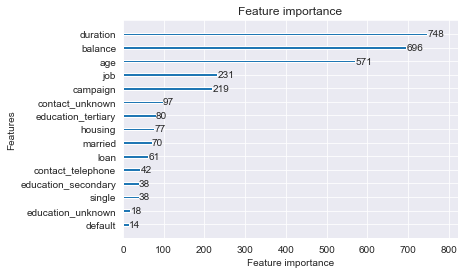

In [101]:
lgb.plot_importance(lgbm)

Just like the random forest model, the LightGBM model shows us that the most important features are duration of the call followed by balance and age.

In [102]:
## create grid parameter for LightGBM

lgbm = lgb.LGBMClassifier()
lgbm_grid = [{'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6, 9],
            'min_data_in_leaf': [10, 50, 100, 500]}]

lgbm_gridsearch = GridSearchCV(estimator=lgbm, 
                             param_grid=lgbm_grid,
                             scoring='accuracy',
                             cv=5)

lgbm_gridsearch.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid=[{'learning_rate': [0.01, 0.1], 'max_depth': [3, 6, 9],
                          'min_data_in_leaf': [10, 50, 100, 500]}],
             scoring='accuracy')

In [103]:
## find out accuracy score

y_hat_train = lgbm_gridsearch.predict(X_train)
y_hat_test = lgbm_gridsearch.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

Training Accuracy:  0.9350714285714286
Testing Accuracy:  0.9333333333333333


Tuning the hyperparameters does not improve model performance, lowering the training accuracy to 94% and the testing accuracy stays the same at 93%.

# XGBoost

In [107]:
## create an xgboost model

xgboost = XGBClassifier(use_label_encoder=False)
xgboost.fit(X_train, y_train)

## find out accuracy score

y_hat_train = xgboost.predict(X_train)
y_hat_test = xgboost.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

[15:40:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy:  0.9629642857142857
Testing Accuracy:  0.9306666666666666


In [108]:
cv = KFold(n_splits=5, random_state=10, shuffle=True)
scores = cross_val_score(xgboost, X_dummies, y, scoring='accuracy', cv=cv)

print('Accuracy: {}'.format(np.mean(scores)))

[15:40:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Just like all the previous models, XGBoost performs very similarly with a training accurayc of 96% and a testing accuracy of 93%.

In [109]:
## create grid parameter for random forest

xgboost = XGBClassifier(use_label_encoder=False)
xgb_grid = [{'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6, 9],
            'min_child_weight': [5, 10, 20],
            'subsample': [0.3, 0.7],
            'n_estimators': [5, 30, 100, 250]}]

xgb_gridsearch = GridSearchCV(estimator=xgboost, 
                             param_grid=xgb_grid,
                             scoring='accuracy',
                             cv=5)

xgb_gridsearch.fit(X_train, y_train)

[15:41:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:41:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:41:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:41:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:42:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:42:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:42:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:43:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:43:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:43:51] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:44:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:44:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:44:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:45:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:45:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:45:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:45:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:46:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:46:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:47:03] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:47:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:23] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:47:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_

In [110]:
## find out accuracy score

y_hat_train = xgb_gridsearch.predict(X_train)
y_hat_test = xgb_gridsearch.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

Training Accuracy:  0.9347142857142857
Testing Accuracy:  0.9346666666666666


Tuning the hyperparameters for xgboost improves the testing accuracy to 93.5% which is a tiny improvement when compared to the other models by ~0.2%.